In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [2]:
import tensorflow as tf

from tensorflow.keras import datasets, models, optimizers
from tensorflow.keras.layers import TimeDistributed, Conv2D, Flatten, Dense, LSTM, ConvLSTM2D, MaxPool2D, Dropout, Conv1D
import matplotlib.pyplot as plt

import numpy as np 
import pandas as pd

In [3]:
tf.test.is_built_with_cuda()

False

In [4]:
tf.compat.v1.enable_eager_execution()

In [6]:
inputs_train = np.load("inputs_train_180.npy")
inputs_test = np.load("inputs_test_180.npy")

In [5]:
import numpy as np
def normalize(data, window, step):
    frame = '_1min'
    values = [c for c in data.columns if frame in c]
    ohlc = data.iloc[step - window + 1:step + 1][values].copy()

    min_low = ohlc[values].min().min()
    for c in ohlc.columns:
        ohlc[c] -= min_low

    max_high = ohlc[values].max().max()
    for c in ohlc.columns:
        ohlc[c] /= max_high

    return ohlc.values

In [6]:
window_size = 180

In [ ]:
%%time
inputs_train = []
for i in range(window_size-1, len(train)):
    if i % 1000 == 0:
        print(i)
    inputs_train.append(normalize(train, window_size , i))
inputs_train = np.array(inputs_train)

In [8]:
%%time
inputs_test = []
for i in range(window_size-1, len(test)):
    if i % 1000 == 0:
        print(i)
    inputs_test.append(normalize(test, window_size , i))
inputs_test = np.array(inputs_test)

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
Wall time: 2min 3s


In [7]:
train = pd.read_csv('train_timeframes.csv').iloc[window_size-1:]
test = pd.read_csv('test_timeframes.csv').iloc[window_size-1:]

In [9]:
df = [train, test]

In [10]:
img = inputs_train[0,:,:]

In [11]:
inputs_train.shape, train.shape

((73516, 180, 4), (73575, 23))

In [12]:
inputs_test.shape, test.shape[0] - (window_size-1)

((24066, 180, 4), 24066)

In [13]:
idx = 0
margin_size = 50
time_limit = 1

In [14]:
def get_model():
    model = models.Sequential()
    # model.add(LSTM(64, input_shape = img.shape, return_sequences=True, dropout=0.2))
    model.add(LSTM(32, input_shape = img.shape, dropout=0.5))
    # model.add(LSTM(32, dropout=0.2))
    model.add(Dense(1, activation="linear"))
    return model

model = get_model()

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 32)                4736      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 4,769
Trainable params: 4,769
Non-trainable params: 0
_________________________________________________________________


In [16]:
buffer_train = train.shape[0] - inputs_train.shape[0] -time_limit - 1
buffer_test = test.shape[0] - inputs_test.shape[0] -time_limit - 1

In [17]:
all_closes_train = tf.convert_to_tensor([df[0].iloc[i:i+1+time_limit]['close_1min'].tolist() for i in range(len(df[0])-buffer_train)])
all_closes_test = tf.convert_to_tensor([df[1].iloc[i:i+1+time_limit]['close_1min'].tolist() for i in range(len(df[1])-buffer_test)])

In [18]:
all_spread_train = tf.convert_to_tensor([df[0].iloc[i:i+1]['spread'].tolist() for i in range(len(df[0])-buffer_train)])
all_spread_test = tf.convert_to_tensor([df[1].iloc[i:i+1]['spread'].tolist() for i in range(len(df[1])-buffer_test)])

In [147]:
np.save(open('all_closes_train', 'wb'), all_closes_train.numpy())
np.save(open('all_closes_test', 'wb'), all_closes_test.numpy())
np.save(open('all_spread_train', 'wb'), all_spread_train.numpy())
np.save(open('all_spread_test', 'wb'), all_spread_test.numpy())

In [30]:
all_closes_train = tf.convert_to_tensor(np.load('all_closes_train.npy'))[:,:,:time_limit+1]
all_closes_test = tf.convert_to_tensor(np.load('all_closes_test.npy'))[:,:,:time_limit+1]
all_spread_train = tf.convert_to_tensor(np.load('all_spread_train.npy'))[:,:,:time_limit+1]
all_spread_test = tf.convert_to_tensor(np.load('all_spread_test.npy'))[:,:,:time_limit+1]

In [19]:
all_closes_train.shape, all_spread_train.shape

(TensorShape([73518, 2]), TensorShape([73518, 1]))

In [121]:
all_closes_train[0], 100 * margin_size *(all_closes_train[0][-1:] - all_closes_train[0][:1])/all_closes_train[0][:1]

(<tf.Tensor: shape=(2,), dtype=float32, numpy=array([1.13622, 1.13597], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([-1.1000594], dtype=float32)>)

In [20]:
def custom_loss_wrapper(idx, margin_size):  
    def custom_loss(y_true, y_pred):
#         print()
#         print(y_pred[:,:1][0].numpy())
#         pred = y_pred[:,0]
#         margin *= margin_size
        
        idxs = y_true[:,1]
        df_name = y_true[0][0]
        closes = tf.cond(df_name == tf.constant(0), lambda: tf.gather(all_closes_train, idxs), lambda: tf.gather(all_closes_test, idxs))
        spread = tf.cond(df_name == tf.constant(0), lambda: tf.gather(all_spread_train, idxs), lambda: tf.gather(all_spread_test, idxs))
        close1 = closes[:,:1]
        close2 = closes[:,-1:]

        diff = close2 - close1
        profit = 100 * margin_size * diff /  close1
#         print(close1[0].numpy(), close2[0].numpy(), margin[0].numpy(), diff[0].numpy(), profit[0].numpy())
#         print(profit.numpy())
#         print(tf.pow(profit, 1.0/3.0).numpy())
#         print(profit.shape, spread.shape, close1.shape, close2.shape)
#         return tf.where(tf.less(tf.abs(profit), 0.5), tf.zeros_like(profit), profit)
#         return tf.where(tf.less(profit, 0), -tf.pow(tf.abs(profit), 1.0/2.0), tf.pow(tf.abs(profit), 1.0/2.0))
#         return tf.where(tf.less(profit, 0), -tf.sqrt(tf.abs(profit)), tf.sqrt(tf.abs(profit)))
#         return tf.where(tf.less(tf.abs(profit), 1), tf.sign(profit)*tf.sqrt(tf.abs(profit)), profit)
#         return tf.pow(profit, 3.0)
        return tf.keras.losses.MSE(profit, y_pred[:,0])
    return custom_loss

In [65]:
def get_profit(data, y_preds, times_spread=0):
    preds = y_preds.flatten()[:-time_limit]
    direction = np.sign(preds)
    b = data.shape[0] - preds.shape[0]
    close1 = data['close_1min'].values[:-b]
    close2 = data['close_1min'].values[time_limit:-b+time_limit]
    diff = close2 - close1
    spread = data['spread'].values[:-b]
    profit = 100 * (margin_size*direction * (diff - (spread*direction))) /  close1
    profit = [p for p, pred, s, c in zip(profit, preds, spread, close1) if abs(pred) > 100*margin_size*times_spread*s/c]
    return profit

In [25]:
from keras.callbacks import Callback

class IntervalEvaluation(Callback):
    def __init__(self, validation_data=(), interval=10):
        super(Callback, self).__init__()

        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(inputs_train[:-buffer_train], verbose=0)
            print(np.min(y_pred, axis=0))
            print(np.mean(y_pred, axis=0))
            print(np.max(y_pred, axis=0))
            print()
            y_pred = self.model.predict(inputs_test[:-buffer_test], verbose=0)
            print(np.min(y_pred, axis=0))
            print(np.mean(y_pred, axis=0))
            print(np.max(y_pred, axis=0))            
            profits = get_profit(df[1], y_pred, times_spread=0)
            print(sum(profits))
#             print("interval evaluation - epoch: {:d} - score: {:.6f} -- score_0: {:.6f}".format(epoch, profits, profits_0))
           
# buffer = (batch_size+time_limit) + 1000
ival = IntervalEvaluation(
    validation_data=(inputs_train[:-buffer_train], np.array([[1, i] for i in range(len(inputs_train)-buffer_train)]))
    , interval=10
)

In [23]:
model = get_model()

In [24]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.0001), #, epsilon=1.0),
    loss=custom_loss_wrapper(idx, margin_size),
#     metrics=[custom_metric_wrapper(idx, stop_limit, price_limit, margin_size, time_limit)],
    run_eagerly=False
)

In [123]:
history = model.fit(
    tf.convert_to_tensor(inputs_train[:-buffer_train]), 
    tf.convert_to_tensor([[0, i] for i in range(len(inputs_train)-buffer_train)]), 
    validation_data=(tf.convert_to_tensor(inputs_test[:-buffer_test]), tf.convert_to_tensor([[1, i] for i in range(len(inputs_test)-buffer_test)])),
    epochs=10000, shuffle=True,
    batch_size=32,
    callbacks=[ival],
    use_multiprocessing=True, verbose=1, 
    validation_freq=10,
    workers=32,
#     initial_epoch=model.history.epoch[-1],
)

Epoch 1/10000
2296/2296 [==============================] - 76s 33ms/step - loss: 3.0286
[-0.00554868]
[-0.00151359]
[0.00371765]

[-0.00515689]
[-0.00154314]
[0.00314912]
-6902.591348148562
Epoch 2/10000
2296/2296 [==============================] - 74s 32ms/step - loss: 3.0285
Epoch 3/10000
2296/2296 [==============================] - 75s 33ms/step - loss: 3.0285
Epoch 4/10000
2296/2296 [==============================] - 75s 33ms/step - loss: 3.0285
Epoch 5/10000
2296/2296 [==============================] - 75s 33ms/step - loss: 3.0285
Epoch 6/10000
2296/2296 [==============================] - 75s 33ms/step - loss: 3.0285
Epoch 7/10000
2296/2296 [==============================] - 75s 33ms/step - loss: 3.0285
Epoch 8/10000
2296/2296 [==============================] - 75s 33ms/step - loss: 3.0284
Epoch 9/10000
2296/2296 [==============================] - 75s 33ms/step - loss: 3.0285
Epoch 10/10000
2296/2296 [==============================] - 81s 35ms/step - loss: 3.0285 - val_loss: 1.169

[-0.00414993]
[0.00567886]
[0.01036614]
-9057.775564861988
Epoch 82/10000
2296/2296 [==============================] - 76s 33ms/step - loss: 3.0285 0s - loss: 3.029
Epoch 83/10000
2296/2296 [==============================] - 75s 33ms/step - loss: 3.0284
Epoch 84/10000
2296/2296 [==============================] - 76s 33ms/step - loss: 3.0284
Epoch 85/10000
2296/2296 [==============================] - 77s 34ms/step - loss: 3.0285
Epoch 86/10000
2296/2296 [==============================] - 77s 33ms/step - loss: 3.0284
Epoch 87/10000
2296/2296 [==============================] - 77s 33ms/step - loss: 3.0285
Epoch 88/10000
2296/2296 [==============================] - 77s 34ms/step - loss: 3.0284
Epoch 89/10000
2296/2296 [==============================] - 77s 34ms/step - loss: 3.0284
Epoch 90/10000
2296/2296 [==============================] - 83s 36ms/step - loss: 3.0284 - val_loss: 1.1698
Epoch 91/10000
2296/2296 [==============================] - 77s 33ms/step - loss: 3.0284
[-0.00082634]
[

2296/2296 [==============================] - 76s 33ms/step - loss: 3.0284
Epoch 163/10000
2296/2296 [==============================] - 77s 33ms/step - loss: 3.0284
Epoch 164/10000
2296/2296 [==============================] - 77s 34ms/step - loss: 3.0283
Epoch 165/10000
2296/2296 [==============================] - 77s 33ms/step - loss: 3.0284
Epoch 166/10000
2296/2296 [==============================] - 77s 34ms/step - loss: 3.0284
Epoch 167/10000
2296/2296 [==============================] - 77s 33ms/step - loss: 3.0284
Epoch 168/10000
2296/2296 [==============================] - 78s 34ms/step - loss: 3.0283
Epoch 169/10000
2296/2296 [==============================] - 78s 34ms/step - loss: 3.0284
Epoch 170/10000
2296/2296 [==============================] - 84s 36ms/step - loss: 3.0284 - val_loss: 1.1694
Epoch 171/10000
2296/2296 [==============================] - 79s 34ms/step - loss: 3.0284
[-0.00464529]
[0.00537883]
[0.00906332]

[-0.0039507]
[0.00531904]
[0.00900529]
-9916.32338020275

KeyboardInterrupt: 

In [29]:
y_pred = model.predict(inputs_test[:-buffer_test], verbose=0)
print(np.min(y_pred, axis=0))
print(np.mean(y_pred, axis=0))
print(np.max(y_pred, axis=0))            

[0.00079171]
[0.01482076]
[0.0253868]


In [63]:
y_pred_train = model.predict(inputs_train[:-buffer_train], verbose=0)
print(np.min(y_pred_train, axis=0))
print(np.mean(y_pred_train, axis=0))
print(np.max(y_pred_train, axis=0)) 

[0.0004175]
[0.01499404]
[0.02602589]


In [116]:
y_pred_train.min()

0.000417504

In [104]:
close1 = train['close_1min'].values[:-time_limit]
close2 = train['close_1min'].values[time_limit:]
diff = close2 - close1
direction = np.sign(diff)
spread = train['spread'].values[:-time_limit]
profit = 100 * (margin_size*direction * (diff - (spread*direction))) /  close1

In [115]:
abs(profit).mean()

0.457255645020063

In [96]:
profits = get_profit(df[1], y_pred, times_spread=0.0395)

In [97]:
sum(profits)

-1035.291307286773

In [94]:
profits_train = get_profit(df[0], y_pred_train, times_spread=0.0395)

In [95]:
sum(profits_train)

2162.1060376512473

In [ ]:
model.save('profit_model_fast')

In [58]:
model.predict(inputs_train[:100])

array([[-0.18511762],
       [-0.16315258],
       [-0.14490741],
       [-0.12828492],
       [-0.11587099],
       [-0.10429251],
       [-0.09419919],
       [-0.08451166],
       [-0.08083578],
       [-0.06614358],
       [-0.06304047],
       [-0.05744674],
       [-0.08215604],
       [-0.07946705],
       [-0.08231978],
       [-0.0613009 ],
       [-0.05833121],
       [-0.06071296],
       [-0.0635265 ],
       [-0.07250223],
       [-0.05633896],
       [-0.05072678],
       [-0.02748454],
       [-0.02112693],
       [-0.06522039],
       [-0.06551221],
       [-0.06433132],
       [-0.07699323],
       [-0.07052597],
       [-0.10773009],
       [-0.10774461],
       [-0.0916043 ],
       [-0.08286908],
       [-0.0802924 ],
       [-0.08301003],
       [-0.08627913],
       [-0.08846469],
       [-0.09030184],
       [-0.09492922],
       [-0.09729075],
       [-0.09824879],
       [-0.09297457],
       [-0.09258007],
       [-0.0908793 ],
       [-0.09150287],
       [-0

In [168]:
y_preds = {'train': model.predict(inputs_train[:-buffer]), 'test': model.predict(inputs_test[:-buffer])}

In [114]:
profits = {'train': get_profit(df[0], y_preds['train'], 0), 'test': get_profit(df[1], y_preds['test'], 0)}

In [116]:
temp = {'train': train.iloc[:-buffer].copy(), 'test': test.iloc[:-buffer].copy()}
temp['train']['pred'] = y_preds['train']
temp['test']['pred'] = y_preds['test']
temp['train']['profit'] = profits['train']
temp['test']['profit'] = profits['test']

<AxesSubplot:xlabel='idx', ylabel='profit'>

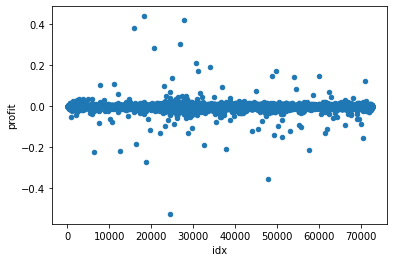

In [108]:
temp['train']['idx'] = temp['train'].index
temp['train'].plot.scatter('idx', 'profit')

<AxesSubplot:xlabel='idx', ylabel='profit'>

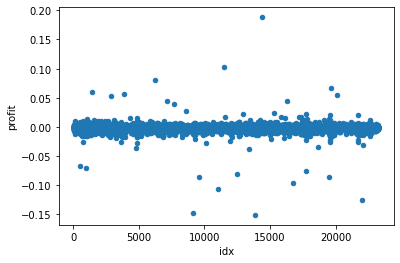

In [109]:
temp['test']['idx'] = temp['test'].index
temp['test'].plot.scatter('idx', 'profit')

In [144]:
temp['train']['pred'].abs().max(), temp['train'][temp['train']['profit'] > 0.4]['pred'].abs().min()

(0.4102172, 0.19561991)

<AxesSubplot:>

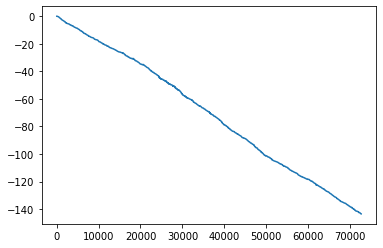

In [139]:
temp['train']['profit'].cumsum().plot()

<AxesSubplot:>

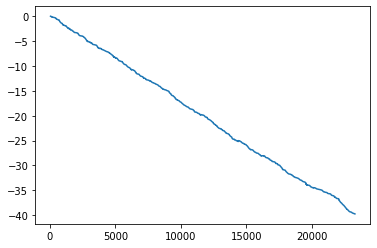

In [81]:
temp['test']['profit'].cumsum().plot()

In [82]:
sum(profits['train'])

-143.49729948486893

In [83]:
sum(profits['test'])

-39.76582186072883

In [84]:
(252 ** 0.5) * np.mean(profits['train']) / np.std(profits['train'])

-4.734169867709254

In [85]:
(252 ** 0.5) * np.mean(profits['test']) / np.std(profits['test'])

-6.869967198065778